In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    623      0 --:--:-- --:--:-- --:--:--   625
100 8863k  100 8863k    0     0  21.2M      0 --:--:-- --:--:-- --:--:--  119M


In [3]:
data_dir = Path("./captcha_images_v2")
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# lables = []
# for img in images:
#   lables.append(img.split(os.path.sep)[-1].split(".png")[0])
# lables
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
# for label in labels:
#   for char in label:
#     print(char)
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

In [4]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'c', 'd', '2', '7', '4', 'p', '5', '6', 'm', 'e', 'x', 'n', 'b', 'g', 'y', '3', '8', 'f', 'w'}


In [5]:
char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary=list(characters),mask_token=None)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [6]:
def split_data(images,labels,train_size=0.9,shuffle=True):
  size = len(images)
  indices = np.arange(size)
  data_size = int(size * train_size)
  if shuffle:
    np.random.shuffle(indices)
  x_train , y_train = images[indices[:data_size]] , labels[indices[:data_size]] 
  x_test , y_test = images[indices[:data_size]] , labels[indices[:data_size]] 
  return x_train,x_test,y_train,y_test


In [7]:
x_train,x_test,y_train,y_test = split_data(np.array(images),np.array(labels))

In [8]:
def encode(image_path,label):
  image = tf.io.read_file(image_path)

  image = tf.io.decode_png(image,channels=1)

  image = tf.image.convert_image_dtype(image,tf.float32)

  image = tf.image.resize(image,[img_height,img_width])
  image = tf.transpose(image,perm=[1,0,2])
  # https://www.tensorflow.org/api_docs/python/tf/transpose
  label = char_to_num(tf.strings.unicode_split(label,input_encoding="UTF-8"))
  return {"image": image, "label": label}

In [11]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_dataset = (
    validation_dataset.map(
        encode, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

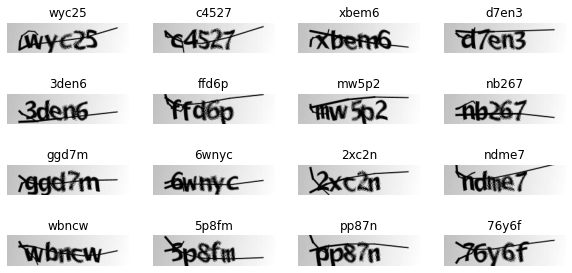

In [17]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

<PrefetchDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>

In [ ]:
def model(input_shape):
  intputs = layers.Input(shape=input_shape,name="image",dtype="float32")
  x = layers.Conv2D(32,(3,3),activation="relu",padding="same",name="Conv1")(inputs)
  x = layers.MaxPool2D((2,2),name="pool1")(x)
  x = layers.Conv2D(64,(3,3),activation="relu",padding="same",name="Conv2")(inputs)
  x = layers.MaxPool2D((2,2),name="pool2")(x)


In [ ]:
input_shape = (img_width,img_height,1)
model(input_shape)